In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torchmetrics

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 12.5 MB/s eta 0:00:00


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
import json
import cv2
import random as rnd
import time
import torch
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import copy
import math
import albumentations as A  # our data augmentation library

from collections import defaultdict, deque
import datetime
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from albumentations.pytorch import ToTensorV2

from torchvision.ops import nms
from operator import itemgetter

import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Generator


In [3]:
SAMPLE_INDEX = 0
class DataHolder:
    def __init__(self, save_backgrounds=False, num_backgrounds=50):
        self.logos = list()
        self.source_bgs = list()
        self.bgs = list()
        self.target_size = (600, 600)
        self.save_backgrounds = save_backgrounds
        self.num_backgrounds = num_backgrounds

    def clean_train() -> None:
      for el in os.listdir('/content/dataset/train/images'):
        os.remove('/content/dataset/train/images/'+el)
      for el in os.listdir('/content/dataset/train/labels'):
          os.remove('/content/dataset/train/labels/'+el)

    def clean_val() -> None:
        for el in os.listdir('/content/dataset/val/images'):
            os.remove('/content/dataset/val/images/'+el)
        for el in os.listdir('/content/dataset/val/labels'):
            os.remove('/content/dataset/val/labels/'+el)

    def clean_test() -> None:
      for el in os.listdir('/content/dataset/test'):
        os.remove('/content/dataset/test/'+el)

    @staticmethod
    def resize_logo(logo: np.array, width = None, height = None, inter = cv2.INTER_AREA) -> np.array:
      dim = None
      (h, w) = logo.shape[:2]
      if width is None and height is None:
          return logo

      if width is None:
          r = height / float(h)
          dim = (int(w * r), height)
      else:
          r = width / float(w)
          dim = (width, int(h * r))

      resized = cv2.resize(logo, dim, interpolation = inter)
      return resized


    def prepare_data(self) -> None:
        for logo in LOGO_URLS:
            lg = cv2.imread(logo, cv2.IMREAD_UNCHANGED)
            self.logos.append(self.resize_logo(lg, 150))
        for bg in BG_URLS:
            back = cv2.imread(bg, cv2.IMREAD_UNCHANGED)
            back = cv2.cvtColor(back, cv2.COLOR_RGB2RGBA)
            self.source_bgs.append(back)
        counter = 0
        f = False
        for _ in range(self.num_backgrounds):
            for bg in self.source_bgs:
                self.generate_bg(bg)
                counter += 1
                if counter == self.num_backgrounds:
                  f = True
                  break
            if f:
              break

        if self.save_backgrounds:
            self.save_generated_backgrounds()

    def save_generated_backgrounds(self) -> None:
        for i, bg in enumerate(self.bgs):
            cv2.imwrite(f"/content/dataset/train/images/sample_{i}.png", bg)


    def generate_bg(self, source_bg: np.array) -> None:
      global SAMPLE_INDEX
      bgs = rnd.sample(self.source_bgs, 3)
      source_bg = cv2.resize(source_bg, self.target_size)
      for bg in bgs:
        scale = rnd.uniform(1.0, 2.5)
        scaled_background = cv2.resize(bg, (int(self.target_size[0] * scale), int(self.target_size[1] * scale)))
        angle = rnd.uniform(-60, 60)
        M = cv2.getRotationMatrix2D((self.target_size[0] / 2, self.target_size[1] / 2), angle, 1)
        rotated_background = cv2.warpAffine(scaled_background, M, self.target_size)
        x_offset = rnd.randint(0, self.target_size[0] - rotated_background.shape[1])
        y_offset = rnd.randint(0, self.target_size[1] - rotated_background.shape[0])
        mask = cv2.threshold(rotated_background, 0, 255, cv2.THRESH_BINARY)[1]
        alpha = rnd.uniform(0.3, 0.6)
        rotated_background_with_alpha = cv2.addWeighted(rotated_background, alpha, source_bg, 1 - alpha, 0)
        source_bg[y_offset:y_offset+self.target_size[1], x_offset:x_offset+self.target_size[0]] = \
            source_bg[y_offset:y_offset+self.target_size[1], x_offset:x_offset+self.target_size[0]] * (1 - mask / 255) + \
            rotated_background_with_alpha * (mask / 255)
      SAMPLE_INDEX += 1
      self.bgs.append(source_bg)

In [4]:
class ImageGenerator:
    def __init__(self, total_images, logos_per_bg_count=(0,2)):
        self.logos_per_bg_count = logos_per_bg_count
        self.total_images = total_images
        self.holder = DataHolder(num_backgrounds=self.total_images//2)
        self.holder.prepare_data()
        self.logos = self.holder.logos
        self.logos_per_image = math.ceil(self.total_images // len(self.logos))

    def main(self):
        global SAMPLE_INDEX_1

        for ind, lg in enumerate(self.logos):
            for i in range(self.logos_per_image):
                lst = []
                clss = []
                bg = rnd.choice(self.holder.bgs)
                t = rnd.randint(self.logos_per_bg_count[0], self.logos_per_bg_count[1])
                if t == 0:
                  images.append(np.copy(bg))
                  SAMPLE_INDEX_1 += 1
                  boxes.append([])
                  continue
                for j in range(t):
                    lg1 = 0
                    if j == 0:
                      lg1 = lg
                    else:
                      lg1 = rnd.choice(self.logos)
                    clss.append(self.logos.index(lg1))
                    lst.append(self.make_logo_roi(lg1, np.copy(bg), i + 1))
                self.make_sample(np.copy(bg), lst, clss, i + 1, SAMPLE_INDEX_1)
                SAMPLE_INDEX_1 += 1

    def make_sample(self, bg: np.array, rois: list, clss: list, sample: int, index: int):
        box_temp = []
        for roi in rois:
            # cv2.addWeighted(roi[4], 1, roi[5], 1, 0)
            ro = bg[roi[0] : roi[1], roi[2] : roi[3]].copy()
            ret, mask = cv2.threshold(roi[4][:, :, 3], 0, 255, cv2.THRESH_BINARY)
            bg1 = cv2.bitwise_or(ro, ro, mask=cv2.bitwise_not(mask))
            fg = cv2.bitwise_and(roi[4], roi[4], mask=mask)
            final_roi = cv2.add(bg1, fg)
            bg[roi[0] : roi[1], roi[2] : roi[3]] = final_roi
            box_temp.append(roi[0:])
        boxes.append(box_temp)

        if 0.15 * self.logos_per_image < sample < 0.25 * self.logos_per_image or 0.65 * self.logos_per_image < sample < 0.75 * self.logos_per_image:
            kernel_size = rnd.randint(5, 15)
            if kernel_size % 2 == 0:
                kernel_size += 1
            bg = cv2.GaussianBlur(bg, (kernel_size, kernel_size), 0)

        label = {
            'boxes': [],
            'labels': [],
            'image_id': [],
            'area': [],
            'iscrowd': []
        }
        for i, roi in enumerate(rois):

            '''x_center = ((roi[2] + roi[3]) / 2) / bg.shape[1]
            y_center = ((roi[0] + roi[1]) / 2) / bg.shape[0]
            norm_width = (roi[3] - roi[2]) / bg.shape[1]
            norm_height = (roi[1] - roi[0]) / bg.shape[0]
            label.append(f"{clss[i]} {x_center} {y_center} {norm_width} {norm_height}\n")'''
            label['boxes'].append([roi[2],roi[0],roi[3],roi[1]])
            label['labels'].append(clss[i]+1)
            label['image_id'].append(SAMPLE_INDEX_1)
            label['area'].append(bg.shape[0]*bg.shape[1])
            label['iscrowd'].append(0)

        label['boxes'] = torch.tensor(label['boxes'], dtype=torch.float32)
        label['labels'] = torch.tensor(label['labels'], dtype=torch.int64)
        label['image_id'] = torch.tensor(label['image_id'])
        label['area'] = torch.tensor(label['area'], dtype=torch.float32)
        label['iscrowd'] = torch.tensor(label['iscrowd'], dtype=torch.int64)

        labels.append(label)

        bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)

        transform = T.Compose([
            T.ToTensor()
        ])

        images.append(transform(bg))

    def make_logo_roi(self, logo: np.array, bg: np.array, sample: int) -> tuple:
        logo = DataHolder.resize_logo(logo, rnd.randint(150, 350), cv2.IMREAD_UNCHANGED)
        logo = ImageGenerator.apply_random_color_distortion(logo)
        if sample < 0.6 * self.logos_per_image:
            logo = ImageGenerator.rotate_logo(logo, rnd.randint(-45, 45))
        logo = ImageGenerator.apply_random_perspective_distortion(logo)
        alpha_channel = logo[:, :, 3]

        non_transparent_pixels = np.column_stack(np.where(alpha_channel > 0))
        min_x, max_x = np.min(non_transparent_pixels[:, 1]), np.max(non_transparent_pixels[:, 1])
        min_y, max_y = np.min(non_transparent_pixels[:, 0]), np.max(non_transparent_pixels[:, 0])
        logo = logo[min_y:max_y+1, min_x:max_x+1]
        bg = cv2.cvtColor(bg, cv2.COLOR_RGB2RGBA)
        x_offset, y_offset = rnd.randint(0, bg.shape[1] - logo.shape[1]), rnd.randint(0, bg.shape[0] - logo.shape[0])
        x_end, y_end = (x_offset + logo.shape[1], y_offset + logo.shape[0])


        return y_offset, y_end, x_offset, x_end, logo

    @staticmethod
    def rotate_logo(logo: np.array, angle: int) -> np.array:
        h, w = logo.shape[:2]
        img_c = (w / 2, h / 2)

        rot = cv2.getRotationMatrix2D(img_c, angle, 1)

        rad = np.radians(angle)
        sin = np.sin(rad)
        cos = np.cos(rad)
        b_w = int((h * abs(sin)) + (w * abs(cos)))
        b_h = int((h * abs(cos)) + (w * abs(sin)))

        rot[0, 2] += ((b_w / 2) - img_c[0])
        rot[1, 2] += ((b_h / 2) - img_c[1])

        outImg = cv2.warpAffine(logo, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
        return outImg

    @staticmethod
    def apply_random_color_distortion(image, max_shift=150):
        red_shift = rnd.randint(-max_shift, max_shift)
        green_shift = rnd.randint(-max_shift, max_shift)
        blue_shift = rnd.randint(-max_shift, max_shift)

        distorted_image = image.copy()
        distorted_image[:, :, 0] = np.clip(image[:, :, 0] + blue_shift, 0, 255)
        distorted_image[:, :, 1] = np.clip(image[:, :, 1] + green_shift, 0, 255)
        distorted_image[:, :, 2] = np.clip(image[:, :, 2] + red_shift, 0, 255)

        return distorted_image

    @staticmethod
    def distance(point1, point2):
        return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    def apply_random_perspective_distortion(image, max_distortion=0.25):
        height, width, _ = image.shape
        points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
        x1 = 0
        y1 = 0
        x2 = width
        y2 = 0
        x3 = 0
        y3 = height
        x4 = width
        y4 = height


        offset_x1 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y1 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x2 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y2 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x3 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y3 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x4 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y4 = rnd.uniform(0, max_distortion) * image.shape[0]

        new_x1, new_y1 = x1 + offset_x1, y1 + offset_y1
        new_x2, new_y2 = x2 + offset_x2, y2 + offset_y2
        new_x3, new_y3 = x3 + offset_x3, y3 + offset_y3
        new_x4, new_y4 = x4 + offset_x4, y4 + offset_y4

        new_width = max(new_x1, new_x2, new_x3, new_x4)
        new_heigth = max(new_y1, new_y2, new_y3, new_y4)

        pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
        pts2 = np.float32([[new_x1, new_y1], [new_x2, new_y2], [new_x3, new_y3], [new_x4, new_y4]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)

        distorted_image = cv2.warpPerspective(image, matrix, (int(new_width), int(new_heigth)))

        return distorted_image

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
LOGO_URLS = ['/content/drive/MyDrive/logo_dataset/logos/'+el for el in os.listdir('/content/drive/MyDrive/logo_dataset/logos/')]
BG_URLS = ['/content/drive/MyDrive/logo_dataset/backgrounds/'+el for el in os.listdir('/content/drive/MyDrive/logo_dataset/backgrounds')]

In [11]:
# Сброс датасета
SAMPLE_INDEX_1 = 0
boxes = []
images = []
labels = []

In [12]:
# Один экземпляр генератора создает изображения с определенными параметрами (Например здесь 60 изображений, на каждом из которых от 0 до 2 логотипов включительно),
# для добавления например еще 100 картинок с 3 логотипами на каждом создается другой генератор ImageGenerator(100, (2, 2)) и так же вызывается метод main
generator = ImageGenerator(100, (1, 2))
generator.main()

#Load Dataset

In [9]:
class LazyDataset:
  def __init__(self, images, labels):
    self.images = images
    self.targets = labels
    self.ids = [i for i in range(len(labels))]

  def __getitem__(self,index):
    id = self.ids[index]
    image = self.images[id]
    target = self.targets[id]

    return image, target

  def __len__(self):
    return len(self.ids)

In [10]:
dataset = LazyDataset(images, labels)

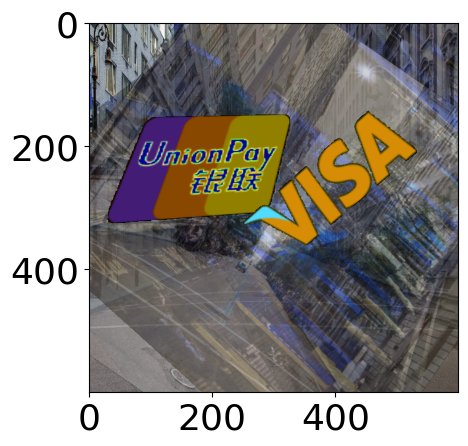

In [96]:
arrImg = dataset[11][0].numpy().transpose(1, 2, 0)
cvImg = cv2.cvtColor(arrImg, cv2.COLOR_RGB2BGR)
plt.imshow(cvImg)

In [97]:
dataset[11][1]

{'boxes': tensor([[ 30., 150., 326., 326.],
         [250., 144., 532., 362.]]),
 'labels': tensor([1, 2]),
 'image_id': tensor([11, 11]),
 'area': tensor([360000., 360000.]),
 'iscrowd': tensor([0, 0])}

In [13]:
val_dataset = LazyDataset(images, labels)

# Train model

In [15]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 3)

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [18]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [19]:
device = torch.device("cuda")
model = model.to(device)

In [20]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=1e-4)

In [28]:
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))
    return all_losses_dict

In [29]:
metric = MeanAveragePrecision(iou_type="bbox").to(device)

In [30]:
def val_one_epoch(model, val_loader):
  model.eval()


  for images, targets in tqdm(val_loader):
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items() if k in ['boxes', 'labels']} for t in targets]

      with torch.no_grad():
          prediction = model(images)

      metric.update(prediction, targets)
      result = metric.compute()

  metric.reset()
  result_dict = pd.DataFrame(result) # for printing
  print("Validation: Epoch {}, lr: {:.6f}, mAP: {:.4f}, mAP50: {:.4f}, mAP75: {:.4f}".format(
      epoch, optimizer.param_groups[0]['lr'], result['map'], result['map_50'], result['map_75']
  ))
  return result

In [31]:
!nvidia-smi

Mon Dec  4 19:34:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |    187MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
train_acc = []
val_acc = []
best_map_75 = 0.0
best_iter = 1
patience_dropLR = 10
dropLR_coef = 2
patience_earlyStop = 15

In [33]:
def dropLR(coef):
    optimizer.param_groups[0]['lr'] /= coef

In [34]:
def save_weights(model, epoch, save_path):
  torch.save(model.state_dict(), f'{save_path}/model_{epoch}_epochs.pth')

In [35]:
num_epochs = 50

for epoch in range(1, num_epochs+1):
    train_acc.append(train_one_epoch(model, optimizer, train_loader, device, epoch))
    val_acc.append(val_one_epoch(model, val_loader))

    if val_acc[-1]['map_75']>best_map_75:
      best_map_75 = val_acc[-1]['map_75']
      best_iter = epoch
      save_weights(model, epoch, '.')

    if (epoch - best_iter) % patience_dropLR == 1:
      dropLR(dropLR_coef)

    if epoch - best_iter == patience_earlyStop:
       break

100%|██████████| 32/32 [00:35<00:00,  1.10s/it]


Epoch 1, lr: 0.001000, loss: 1.286388, loss_classifier: 0.532664, loss_box: 0.713456, loss_rpn_box: 0.009794, loss_object: 0.030473


100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


Validation: Epoch 1, lr: 0.001000, mAP: 0.6019, mAP50: 0.9149, mAP75: 0.7480


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 2, lr: 0.001000, loss: 0.912526, loss_classifier: 0.309615, loss_box: 0.589351, loss_rpn_box: 0.006396, loss_object: 0.007164


100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


Validation: Epoch 2, lr: 0.001000, mAP: 0.7572, mAP50: 0.9498, mAP75: 0.8562


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Epoch 3, lr: 0.001000, loss: 0.673520, loss_classifier: 0.241698, loss_box: 0.422775, loss_rpn_box: 0.004494, loss_object: 0.004554


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Validation: Epoch 3, lr: 0.001000, mAP: 0.7650, mAP50: 0.9505, mAP75: 0.9046


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Epoch 4, lr: 0.001000, loss: 0.584185, loss_classifier: 0.213368, loss_box: 0.362621, loss_rpn_box: 0.003993, loss_object: 0.004202


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Validation: Epoch 4, lr: 0.001000, mAP: 0.8081, mAP50: 0.9549, mAP75: 0.9066


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Epoch 5, lr: 0.001000, loss: 0.537278, loss_classifier: 0.197951, loss_box: 0.332345, loss_rpn_box: 0.003715, loss_object: 0.003266


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Validation: Epoch 5, lr: 0.001000, mAP: 0.8144, mAP50: 0.9523, mAP75: 0.9224


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Epoch 6, lr: 0.001000, loss: 0.493169, loss_classifier: 0.184492, loss_box: 0.302025, loss_rpn_box: 0.003424, loss_object: 0.003228


100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Validation: Epoch 6, lr: 0.001000, mAP: 0.8330, mAP50: 0.9562, mAP75: 0.9322


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Epoch 7, lr: 0.001000, loss: 0.462672, loss_classifier: 0.171482, loss_box: 0.285218, loss_rpn_box: 0.003246, loss_object: 0.002725


100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Validation: Epoch 7, lr: 0.001000, mAP: 0.8282, mAP50: 0.9746, mAP75: 0.9432


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 8, lr: 0.001000, loss: 0.444477, loss_classifier: 0.163494, loss_box: 0.275150, loss_rpn_box: 0.003149, loss_object: 0.002685


100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Validation: Epoch 8, lr: 0.001000, mAP: 0.8435, mAP50: 0.9582, mAP75: 0.9221


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 9, lr: 0.000500, loss: 0.415198, loss_classifier: 0.156831, loss_box: 0.252760, loss_rpn_box: 0.003050, loss_object: 0.002557


100%|██████████| 7/7 [00:01<00:00,  3.59it/s]


Validation: Epoch 9, lr: 0.000500, mAP: 0.8415, mAP50: 0.9585, mAP75: 0.9397


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 10, lr: 0.000500, loss: 0.393868, loss_classifier: 0.150758, loss_box: 0.237936, loss_rpn_box: 0.002932, loss_object: 0.002242


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


Validation: Epoch 10, lr: 0.000500, mAP: 0.8559, mAP50: 0.9715, mAP75: 0.9445


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Epoch 11, lr: 0.000500, loss: 0.392291, loss_classifier: 0.150548, loss_box: 0.236666, loss_rpn_box: 0.002936, loss_object: 0.002140


100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Validation: Epoch 11, lr: 0.000500, mAP: 0.8527, mAP50: 0.9711, mAP75: 0.9398


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 12, lr: 0.000250, loss: 0.374612, loss_classifier: 0.144792, loss_box: 0.224826, loss_rpn_box: 0.002913, loss_object: 0.002081


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Validation: Epoch 12, lr: 0.000250, mAP: 0.8543, mAP50: 0.9709, mAP75: 0.9444


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 13, lr: 0.000250, loss: 0.367589, loss_classifier: 0.141726, loss_box: 0.220965, loss_rpn_box: 0.002854, loss_object: 0.002045


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Validation: Epoch 13, lr: 0.000250, mAP: 0.8526, mAP50: 0.9707, mAP75: 0.9356


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 14, lr: 0.000250, loss: 0.366712, loss_classifier: 0.139724, loss_box: 0.222021, loss_rpn_box: 0.002873, loss_object: 0.002094


100%|██████████| 7/7 [00:02<00:00,  3.35it/s]


Validation: Epoch 14, lr: 0.000250, mAP: 0.8557, mAP50: 0.9707, mAP75: 0.9356


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 15, lr: 0.000250, loss: 0.359058, loss_classifier: 0.137880, loss_box: 0.216294, loss_rpn_box: 0.002808, loss_object: 0.002076


100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Validation: Epoch 15, lr: 0.000250, mAP: 0.8658, mAP50: 0.9788, mAP75: 0.9532


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 16, lr: 0.000250, loss: 0.354360, loss_classifier: 0.136121, loss_box: 0.213316, loss_rpn_box: 0.002860, loss_object: 0.002062


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Validation: Epoch 16, lr: 0.000250, mAP: 0.8623, mAP50: 0.9796, mAP75: 0.9496


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 17, lr: 0.000125, loss: 0.349346, loss_classifier: 0.135128, loss_box: 0.209370, loss_rpn_box: 0.002806, loss_object: 0.002042


100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Validation: Epoch 17, lr: 0.000125, mAP: 0.8650, mAP50: 0.9800, mAP75: 0.9535


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 18, lr: 0.000125, loss: 0.347555, loss_classifier: 0.136237, loss_box: 0.206257, loss_rpn_box: 0.002898, loss_object: 0.002162


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


Validation: Epoch 18, lr: 0.000125, mAP: 0.8720, mAP50: 0.9800, mAP75: 0.9535


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 19, lr: 0.000125, loss: 0.343070, loss_classifier: 0.134087, loss_box: 0.204054, loss_rpn_box: 0.002857, loss_object: 0.002072


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Validation: Epoch 19, lr: 0.000125, mAP: 0.8714, mAP50: 0.9803, mAP75: 0.9445


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 20, lr: 0.000063, loss: 0.351542, loss_classifier: 0.138001, loss_box: 0.208739, loss_rpn_box: 0.002815, loss_object: 0.001987


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Validation: Epoch 20, lr: 0.000063, mAP: 0.8678, mAP50: 0.9804, mAP75: 0.9445


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 21, lr: 0.000063, loss: 0.342596, loss_classifier: 0.133048, loss_box: 0.204720, loss_rpn_box: 0.002784, loss_object: 0.002045


100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Validation: Epoch 21, lr: 0.000063, mAP: 0.8671, mAP50: 0.9803, mAP75: 0.9401


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 22, lr: 0.000063, loss: 0.335587, loss_classifier: 0.131081, loss_box: 0.199734, loss_rpn_box: 0.002780, loss_object: 0.001992


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Validation: Epoch 22, lr: 0.000063, mAP: 0.8666, mAP50: 0.9804, mAP75: 0.9401


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 23, lr: 0.000063, loss: 0.336547, loss_classifier: 0.130972, loss_box: 0.200896, loss_rpn_box: 0.002783, loss_object: 0.001895


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Validation: Epoch 23, lr: 0.000063, mAP: 0.8660, mAP50: 0.9806, mAP75: 0.9401


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 24, lr: 0.000063, loss: 0.336950, loss_classifier: 0.130299, loss_box: 0.202045, loss_rpn_box: 0.002754, loss_object: 0.001852


100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Validation: Epoch 24, lr: 0.000063, mAP: 0.8716, mAP50: 0.9804, mAP75: 0.9401


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 25, lr: 0.000063, loss: 0.336980, loss_classifier: 0.130426, loss_box: 0.201908, loss_rpn_box: 0.002817, loss_object: 0.001829


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Validation: Epoch 25, lr: 0.000063, mAP: 0.8678, mAP50: 0.9804, mAP75: 0.9401


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Epoch 26, lr: 0.000063, loss: 0.332239, loss_classifier: 0.130062, loss_box: 0.197405, loss_rpn_box: 0.002775, loss_object: 0.001997


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Validation: Epoch 26, lr: 0.000063, mAP: 0.8682, mAP50: 0.9805, mAP75: 0.9401


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 27, lr: 0.000063, loss: 0.333108, loss_classifier: 0.129599, loss_box: 0.198769, loss_rpn_box: 0.002797, loss_object: 0.001943


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Validation: Epoch 27, lr: 0.000063, mAP: 0.8692, mAP50: 0.9804, mAP75: 0.9446


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 28, lr: 0.000063, loss: 0.329647, loss_classifier: 0.127970, loss_box: 0.197006, loss_rpn_box: 0.002739, loss_object: 0.001932


100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Validation: Epoch 28, lr: 0.000063, mAP: 0.8680, mAP50: 0.9805, mAP75: 0.9401


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 29, lr: 0.000063, loss: 0.331684, loss_classifier: 0.129882, loss_box: 0.197040, loss_rpn_box: 0.002782, loss_object: 0.001980


100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Validation: Epoch 29, lr: 0.000063, mAP: 0.8736, mAP50: 0.9805, mAP75: 0.9447


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 30, lr: 0.000031, loss: 0.329209, loss_classifier: 0.127806, loss_box: 0.196770, loss_rpn_box: 0.002734, loss_object: 0.001899


100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Validation: Epoch 30, lr: 0.000031, mAP: 0.8704, mAP50: 0.9805, mAP75: 0.9447


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Epoch 31, lr: 0.000031, loss: 0.332695, loss_classifier: 0.128703, loss_box: 0.199300, loss_rpn_box: 0.002754, loss_object: 0.001939


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Validation: Epoch 31, lr: 0.000031, mAP: 0.8713, mAP50: 0.9805, mAP75: 0.9447


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Epoch 32, lr: 0.000031, loss: 0.326550, loss_classifier: 0.127614, loss_box: 0.194306, loss_rpn_box: 0.002736, loss_object: 0.001894


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Validation: Epoch 32, lr: 0.000031, mAP: 0.8704, mAP50: 0.9805, mAP75: 0.9447


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Epoch 33, lr: 0.000031, loss: 0.324511, loss_classifier: 0.127309, loss_box: 0.192599, loss_rpn_box: 0.002726, loss_object: 0.001879


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]

Validation: Epoch 33, lr: 0.000031, mAP: 0.8691, mAP50: 0.9805, mAP75: 0.9447


<Axes: xlabel='Epochs', ylabel='Score'>

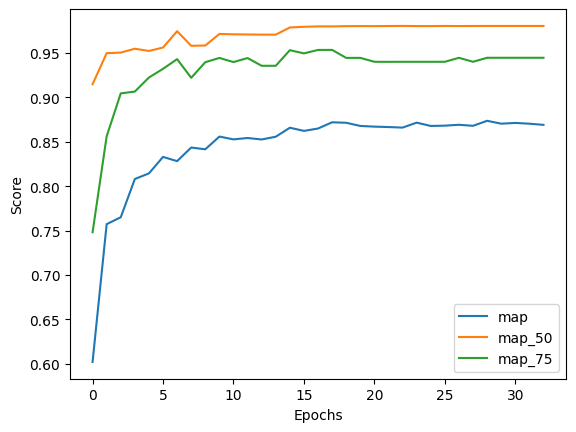

In [36]:
val_scores_df =pd.DataFrame(val_acc)
val_scores_df['map'] = val_scores_df['map'].astype(float)
val_scores_df['map_50'] = val_scores_df['map_50'].astype(float)
val_scores_df['map_75'] = val_scores_df['map_75'].astype(float)
val_scores_df.plot(y=["map", "map_50", "map_75"], xlabel='Epochs', ylabel='Score')

# Predict on real data

In [ ]:
def load_test_data(images_path, classes, transform, collate_fn, batch_size):
  test_dataset = LogoDetection(root='.', split=images_path, transforms=transform)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

  return next(iter(test_loader))

In [ ]:
def pred_with_nms(model, image, iou_threshold):
  pred = model([image.to(device)])
  nms_idx = nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold)
  nms_pred = {
    'boxes': itemgetter(nms_idx)(pred[0]['boxes']),
    'labels': itemgetter(nms_idx)(pred[0]['labels']),
    'scores': itemgetter(nms_idx)(pred[0]['scores'])
  }
  prediction = [dict(
              boxes=nms_pred['boxes'].to('cpu'),
              scores=nms_pred['scores'].to('cpu'),
              labels=nms_pred['labels'].to('cpu')
             )]

  return prediction

In [ ]:
classes = ['tinkoff', 'naumen', 'ussc', 'rostelecom', 'sber', 'gosuslugi']

In [ ]:
transform = A.Compose([ToTensorV2()], bbox_params=A.BboxParams(format='coco'))

In [ ]:
images, labels = load_test_data("./dataset/test/images", classes, transform, collate_fn, 32)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
device = torch.device("cuda")
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn() # we do not specify ``weights``, i.e. create untrained model
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 7)
model.load_state_dict(torch.load('./model_25_epochs.pth'))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [ ]:
#predicts loop
metric = MeanAveragePrecision(iou_type="bbox")

for i in range(len(images)):
  target = [dict(
          boxes=labels[i]['boxes'],
          labels=labels[i]['labels']
         )]
  prediction = pred_with_nms(model, images[i], 0.05)

  metric.update(prediction, target)

print(metric.compute())
metric.reset()

{'map': tensor(0.), 'map_50': tensor(0.), 'map_75': tensor(0.), 'map_small': tensor(-1.), 'map_medium': tensor(0.), 'map_large': tensor(0.), 'mar_1': tensor(0.), 'mar_10': tensor(0.), 'mar_100': tensor(0.), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2, 3, 4, 5, 6], dtype=torch.int32)}


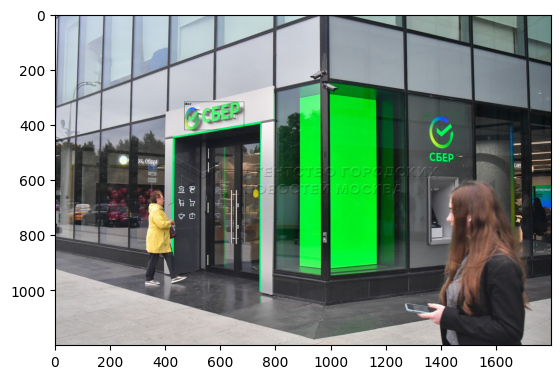

In [ ]:
plt.imshow(draw_bounding_boxes(torch.tensor(images[0]*255, dtype=torch.uint8),  labels[0]['boxes'], [classes[i-1] for i in labels[0]['labels'].tolist()]).permute(1,2,0))

In [ ]:
nms_pred = pred_with_nms(model, images[0], 0.05)

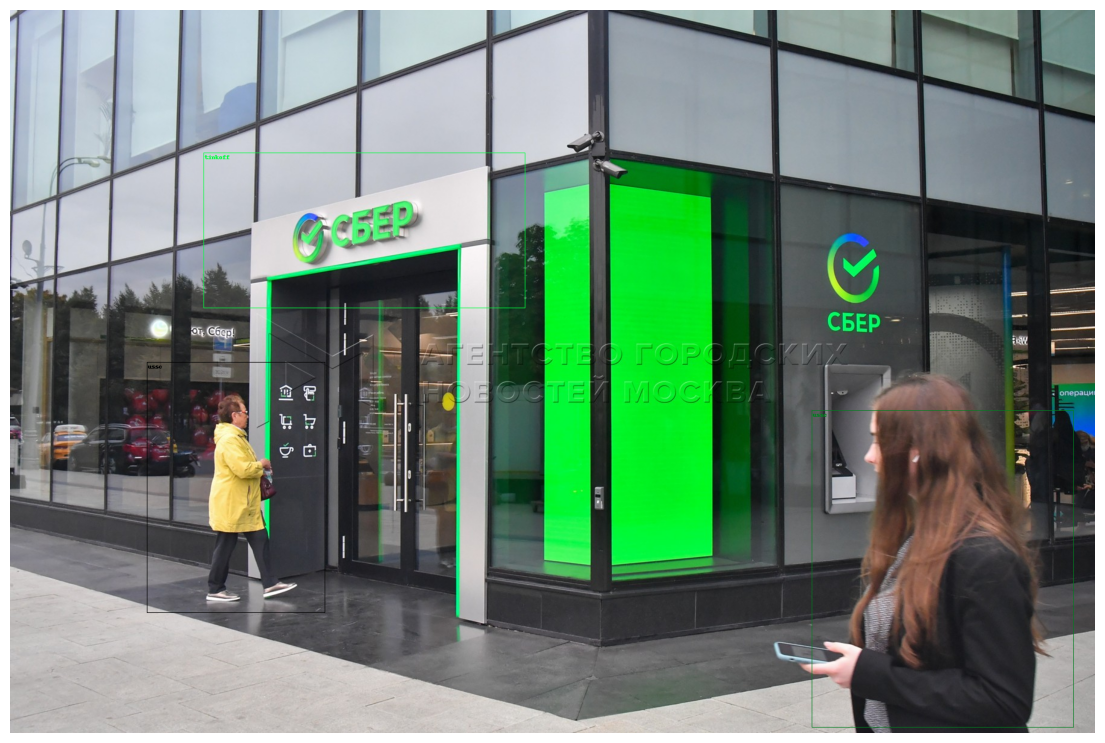

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.axis('off')
plt.imshow(draw_bounding_boxes(torch.tensor(images[0]*255, dtype=torch.uint8),  nms_pred[0]['boxes'], [classes[i-1] for i in nms_pred[0]['labels'].tolist()]).permute(1,2,0))

In [ ]:
torch.cuda.empty_cache()

# Predict on sample Images

In [37]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [63]:
classes = ['unionpay','visa']

In [ ]:
#load weights to model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn() # we do not specify ``weights``, i.e. create untrained model
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, 3)
model.load_state_dict(torch.load('/content/model_18_epochs.pth'))
model.to(device)
model.eval()

In [70]:
def single_image_prediction(image_path: str, save_path: str, threshold: float) -> None:
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  transform = T.Compose([
      T.ToTensor()
  ])
  tensor = transform(image)

  img_int = torch.tensor(tensor*255, dtype=torch.uint8)
  with torch.no_grad():
      prediction = model([tensor.to(device)])
      pred = prediction[0]

  fig = plt.figure(figsize=(14, 10))
  plt.axis('off')
  plt.rcParams.update({'font.size': 26})
  plt.imshow(draw_bounding_boxes(img_int,
      pred['boxes'][pred['scores'] > threshold],
      [classes[i-1] for i in pred['labels'][pred['scores'] > threshold].tolist()], width=4,font_size=48,
      colors="green"
  ).permute(1, 2, 0))
  plt.savefig(save_path, bbox_inches='tight', pad_inches = 0)

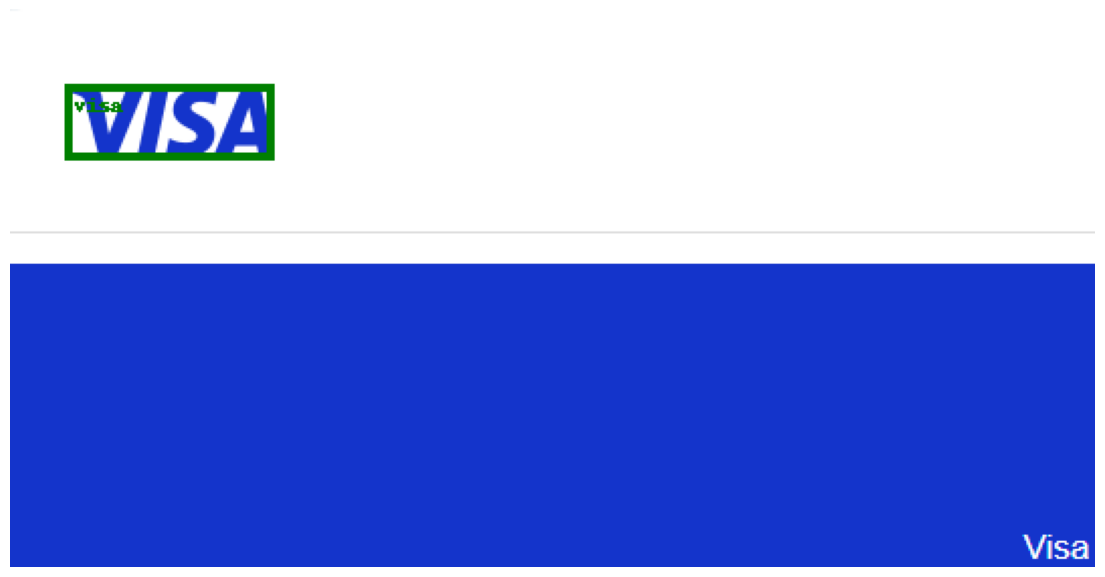

In [81]:
single_image_prediction('/content/Снимок экрана 2023-12-05 012912.png','_predict.png', 0.75)

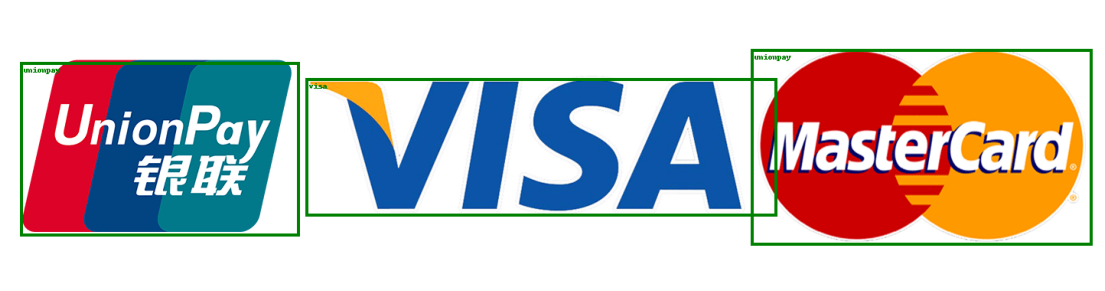

In [82]:
single_image_prediction('/content/transparent-logo-visa.png','_predict.png', 0.75)

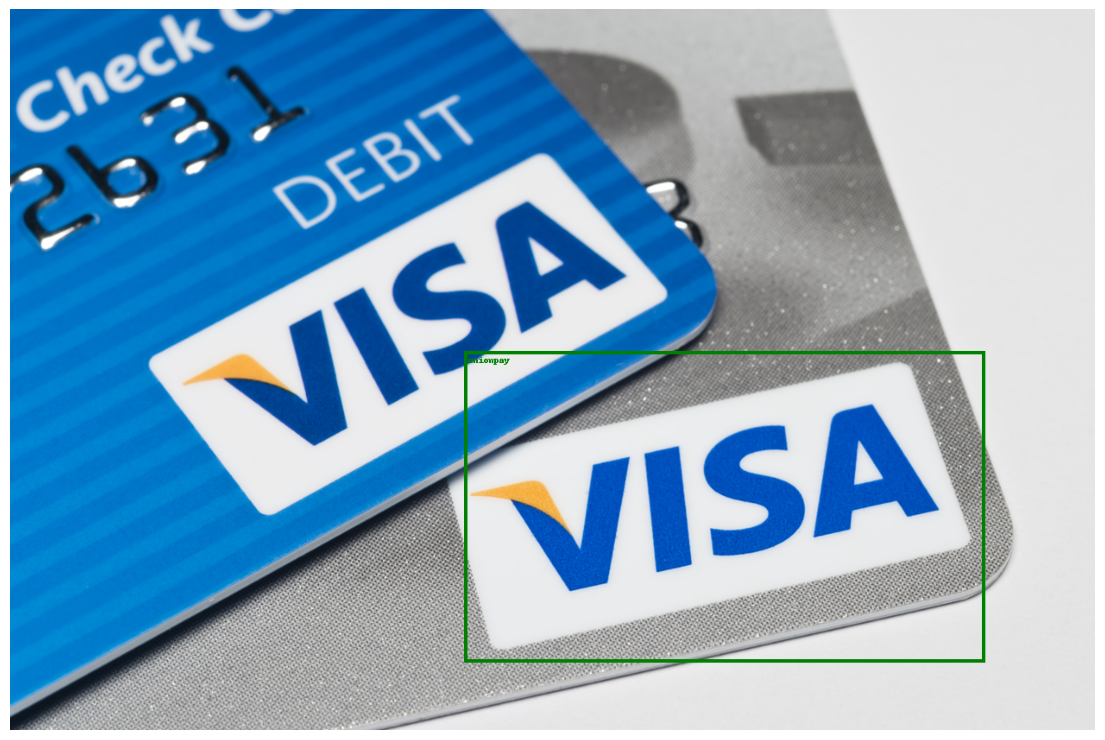

In [86]:
single_image_prediction('/content/image_2023-11-21_00-12-52 (2).png','_predict.png', 0.75)

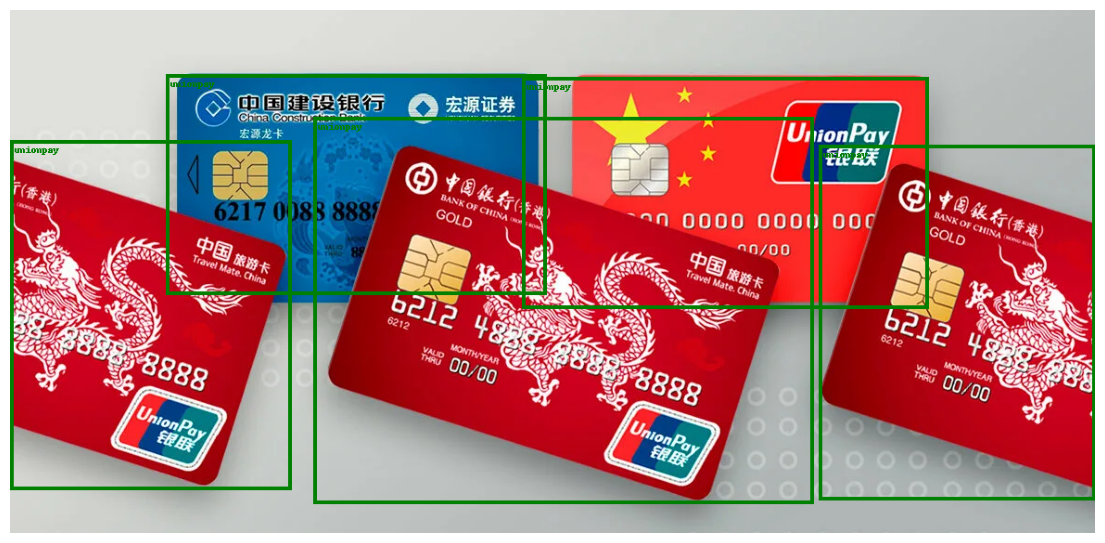

In [87]:
single_image_prediction('/content/image_2023-11-21_00-12-57 (2).png','_predict.png', 0.75)

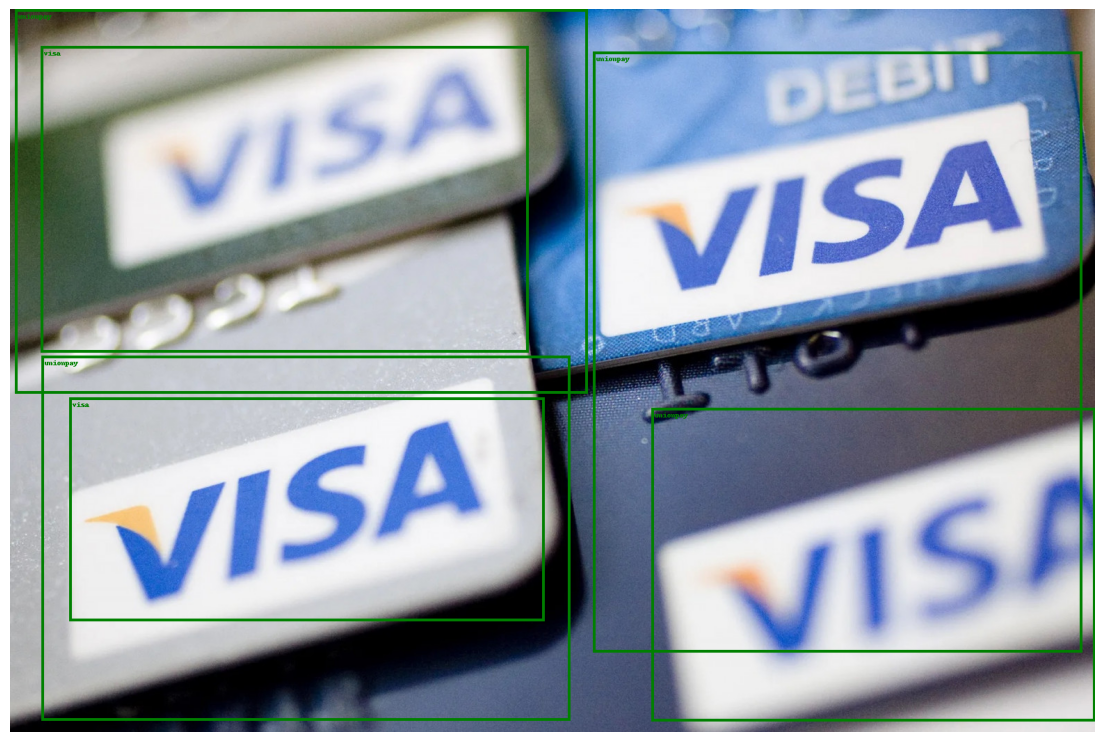

In [93]:
single_image_prediction('/content/1.jpeg','_predict.png', 0.2)